# Real vs fake news prediction model

## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, tree
from sklearn.linear_model import SGDClassifier, LogisticRegression

## Read in datasets

In [2]:
real_df = pd.read_csv('~/documents/Data/Fake vs Real News/real_eng.csv', index_col = 0)
fake_df = pd.read_csv('~/documents/Data/Fake vs Real News/fake_eng.csv', index_col = 0)

## Transform data to correct format for sklearn modelling

#### Add a column to specify whether an article is real or fake

In [3]:
real_df['real_or_fake'] = 'real'
fake_df['real_or_fake'] = 'fake'

#### Concatenate the two articles into a single dataframe

In [4]:
news_df = pd.concat([real_df, fake_df])

#### Shuffle the rows of the dataframe

In [5]:
news_df = news_df.sample(frac = 1, random_state = 42)

In [6]:
news_df.sample(frac=1).head()

,title,text,length_title,proportion_capitals_title,real_or_fake
11428,"Guatemala to move embassy to Jerusalem, backin...",GUATEMALA CITY (Reuters) - Guatemalan Presiden...,53,0.056604,real
15058,Trump: Being friends with North Korea's Kim is...,HANOI (Reuters) - U.S. President Donald Trump ...,55,0.090909,real
10496,Foreign policy thinkers praised by Trump have ...,WASHINGTON (Reuters) - If Americans were looki...,61,0.032787,real
5307,WATCH: Fox News Host DEFENDS Slavery In Bizar...,"Fox News most popular prime time host, Bill O...",53,0.358491,fake
6921,"Louisiana’s Dem. Governor Steps Up, Signs Exe...","Could anyone, in a million years, ever see Bob...",87,0.160920,fake


#### Feature and target columns

In [7]:
X = news_df[['length_title', 'proportion_capitals_title']]
y = news_df['real_or_fake']

#### Standardise the feature columns

In [8]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

#### Split the data into a training set and a testing set

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

## Logistic Regression Classifier

#### Fit the model to the dataset

In [10]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

#### Model accuracy

In [11]:
score = accuracy_score(y_test, y_pred)
print(score)

0.9892610585527998


#### Confusion matrix

In [12]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[1722   25]
 [  17 2147]]


#### Results for model comparison

In [13]:
model_comparison = pd.DataFrame({'Accuracy score (%)' : [round(score * 100, 1)],
                                'False negative rate (%)' : [round(conf_mat[0, 1] / conf_mat[0, 0] * 100, 1)],
                                'False positive rate (%)' : [round(conf_mat[1, 0] / conf_mat[1, 1] * 100, 1)]})

model_comparison.index = model_comparison.index.map(str)
model_comparison.index = ['Logistic regression']

## K-Nearest Neighbours Classifier

#### Set up the hyperparameter space for tuning

In [14]:
k_space = np.arange(2, 20, 2)

#### Initialise the cross-validation scores array

In [15]:
cv_scores = []

#### Fit the model to the dataset

In [16]:
tic = time.perf_counter()
for k in k_space:
    knn = KNeighborsClassifier(n_neighbors = k)
    cv_score = np.mean(cross_val_score(knn, X_train, y_train, cv = 5))
    cv_scores.append(cv_score)
toc = time.perf_counter()
print(round(toc - tic, 0), 'seconds')

11.0 seconds


#### Model accuracy

    k  Cross-validation scores
0   2                 0.979513
1   4                 0.983832
2   6                 0.984514
3   8                 0.985025
4  10                 0.985196
5  12                 0.984997
6  14                 0.985651
7  16                 0.985281
8  18                 0.985253


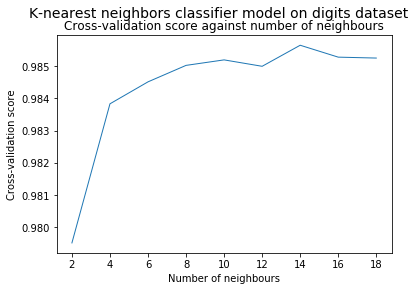

In [17]:
print(pd.DataFrame({'k': k_space,
                   'Cross-validation scores': cv_scores}))

plt.plot(k_space, cv_scores, linewidth = 1)
plt.suptitle('K-nearest neighbors classifier model on digits dataset', size = 14)
plt.title('Cross-validation score against number of neighbours')
plt.xlabel('Number of neighbours')
plt.ylabel('Cross-validation score')
plt.xticks(k_space)
plt.show()

#### Best model

In [18]:
knn = KNeighborsClassifier(n_neighbors = 14)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

#### Best model score

In [19]:
score = accuracy_score(y_test, y_pred)
print(score)

0.988238302224495


#### Best model confusion matrix

In [20]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[1730   17]
 [  29 2135]]


#### Results for model comparison

In [21]:
mc = pd.Series({'Accuracy score (%)' : round(score * 100, 1),
                   'False negative rate (%)' : round(conf_mat[0, 1] / conf_mat[0, 0] * 100, 1),
                   'False positive rate (%)' : round(conf_mat[1, 0] / conf_mat[1, 1] * 100, 1)},
                 name = 'K nearest neighbours')

model_comparison = model_comparison.append(mc)

## Support vector machine classifier

#### Set up the hyperparameter space for tuning

In [22]:
C_space = np.arange(0.01, 0.05, 0.005)

#### Initialise the cross-validation scores array

In [23]:
cv_scores = []

#### Fit the model to the dataset

In [24]:
tic = time.perf_counter()
for C in C_space:
    svc = svm.LinearSVC(C = C, max_iter = 2000)
    cv_score = np.mean(cross_val_score(svc, X_train, y_train, cv = 5))
    cv_scores.append(cv_score)
toc = time.perf_counter()
print(round(toc - tic, 0), 'seconds')

2.0 seconds


#### Model accuracy

       C  Cross-validation scores
0  0.010                 0.984997
1  0.015                 0.985139
2  0.020                 0.985167
3  0.025                 0.985281
4  0.030                 0.985281
5  0.035                 0.985196
6  0.040                 0.985196
7  0.045                 0.985196


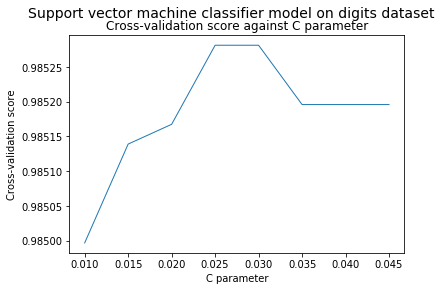

In [25]:
print(pd.DataFrame({'C': C_space,
                   'Cross-validation scores': cv_scores}))

plt.plot(C_space, cv_scores, linewidth = 1)
plt.suptitle('Support vector machine classifier model on digits dataset', size = 14)
plt.title('Cross-validation score against C parameter')
plt.xlabel('C parameter')
plt.ylabel('Cross-validation score')
plt.show()

#### Best model

In [26]:
svc = svm.LinearSVC(C = 0.025, max_iter = 2000)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

#### Best model score

In [27]:
score = accuracy_score(y_test, y_pred)
print(score)

0.989516747634876


#### Best model confusion matrix

In [28]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[1722   25]
 [  16 2148]]


#### Results for model comparison

In [29]:
mc = pd.Series({'Accuracy score (%)' : round(score * 100, 1),
                   'False negative rate (%)' : round(conf_mat[0, 1] / conf_mat[0, 0] * 100, 1),
                   'False positive rate (%)' : round(conf_mat[1, 0] / conf_mat[1, 1] * 100, 1)},
                 name = 'Support vector machine')

model_comparison = model_comparison.append(mc)

# Stochastic gradient descent classifier

#### Set up the hyperparameter space for tuning

In [30]:
alpha_space = np.arange(5e-6, 2e-5, 1e-6)

#### Initialise the cross-validation scores array

In [31]:
cv_scores = []

#### Fit the model to the dataset

In [32]:
tic = time.perf_counter()
for a in alpha_space:
    sgdc = SGDClassifier(alpha = a)
    cv_score = np.mean(cross_val_score(sgdc, X_train, y_train, cv = 5))
    cv_scores.append(cv_score)
toc = time.perf_counter()
print(round(toc - tic, 0), 'seconds')

5.0 seconds


#### Model accuracy

       alpha  Cross-validation scores
0   0.000005                 0.982042
1   0.000006                 0.984542
2   0.000007                 0.984031
3   0.000008                 0.984343
4   0.000009                 0.984599
5   0.000010                 0.984883
6   0.000011                 0.984599
7   0.000012                 0.984486
8   0.000013                 0.985310
9   0.000014                 0.983377
10  0.000015                 0.984287
11  0.000016                 0.983036
12  0.000017                 0.984826
13  0.000018                 0.985423
14  0.000019                 0.984883
15  0.000020                 0.984486


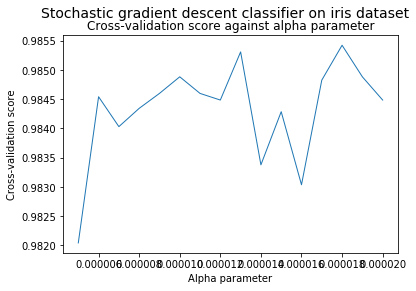

In [33]:
print(pd.DataFrame({'alpha': alpha_space,
                   'Cross-validation scores': cv_scores}))

plt.plot(alpha_space, cv_scores, linewidth = 1)
plt.suptitle('Stochastic gradient descent classifier on iris dataset', size = 14)
plt.title('Cross-validation score against alpha parameter')
plt.xlabel('Alpha parameter')
plt.ylabel('Cross-validation score')
plt.show()

#### Best model

In [34]:
sgdc = SGDClassifier(alpha = 1.5e-5)
sgdc.fit(X_train, y_train)
y_pred = sgdc.predict(X_test)

#### Best model score

In [35]:
score = accuracy_score(y_test, y_pred)
print(score)

0.986959856814114


#### Best model confusion matrix

In [36]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[1735   12]
 [  39 2125]]


#### Results for model comparison

In [37]:
mc = pd.Series({'Accuracy score (%)' : round(score * 100, 1),
                   'False negative rate (%)' : round(conf_mat[0, 1] / conf_mat[0, 0] * 100, 1),
                   'False positive rate (%)' : round(conf_mat[1, 0] / conf_mat[1, 1] * 100, 1)},
                 name = 'Stochastic gradient descent')

model_comparison = model_comparison.append(mc)

## Decision tree classifier

#### Set up the parameter space

In [38]:
max_depth_space = np.arange(1, 12, 1)

#### Initialise the cross-validation scores array

In [39]:
cv_scores = []

#### Fit the model to the dataset

In [40]:
tic = time.perf_counter()
for d in max_depth_space:
    dec_tree = tree.DecisionTreeClassifier(max_depth = d)
    cv_score = np.mean(cross_val_score(dec_tree, X_train, y_train, cv = 5))
    cv_scores.append(cv_score)
toc = time.perf_counter()
print(round(toc - tic, 0), 'seconds')

3.0 seconds


#### Model accuracy

    max_depth  Cross-validation scores
0           1                 0.982070
1           2                 0.982070
2           3                 0.984372
3           4                 0.984940
4           5                 0.985167
5           6                 0.985025
6           7                 0.984940
7           8                 0.984713
8           9                 0.984684
9          10                 0.984400
10         11                 0.984457


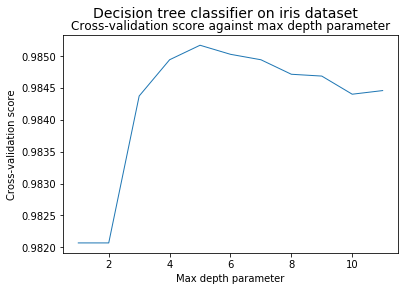

In [41]:
print(pd.DataFrame({'max_depth': max_depth_space,
                   'Cross-validation scores': cv_scores}))

plt.plot(max_depth_space, cv_scores, linewidth = 1)
plt.suptitle('Decision tree classifier on iris dataset', size = 14)
plt.title('Cross-validation score against max depth parameter')
plt.xlabel('Max depth parameter')
plt.ylabel('Cross-validation score')
plt.show()

#### Best model

In [42]:
dec_tree = tree.DecisionTreeClassifier(max_depth = 5)
dec_tree.fit(X_train, y_train)
y_pred = dec_tree.predict(X_test)

#### Best model score

In [43]:
score = accuracy_score(y_test, y_pred)
print(score)

0.986959856814114


#### Best model confusion matrix

In [44]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[1732   15]
 [  36 2128]]


#### Results for model comparison

In [45]:
mc = pd.Series({'Accuracy score (%)' : round(score * 100, 1),
                   'False negative rate (%)' : round(conf_mat[0, 1] / conf_mat[0, 0] * 100, 1),
                   'False positive rate (%)' : round(conf_mat[1, 0] / conf_mat[1, 1] * 100, 1)},
                 name = 'Decision tree')

model_comparison = model_comparison.append(mc)

## Final results

In [48]:
model_comparison

,Accuracy score (%),False negative rate (%),False positive rate (%)
Logistic regression,98.9,1.5,0.8
K nearest neighbours,98.8,1.0,1.4
Support vector machine,99.0,1.5,0.7
Stochastic gradient descent,98.7,0.7,1.8
Decision tree,98.7,0.9,1.7
